# Evaluation
## Daten und Model
Hier werden die Daten und das Model geladen und für die Evaluation vorbereitet.

In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt

valencia_data = pd.read_csv(os.path.join("weather_energy_join_1.csv"))
valencia_data.drop(["city_name"], axis=1, inplace=True)

df = pd.DataFrame(valencia_data)

df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

df.drop(["timestamp"], axis=1, inplace=True)


columns_to_scale = [['temperature','generation_solar', 'generation_wind_onshore', 'total_energy_demand', 'humidity', 'clouds_coverage','wind_speed','hour', 'dayofweek', 'month']]

for column in columns_to_scale:
    column_min = df[column].min()
    column_max = df[column].max()
    df[column] = (df[column] - column_min) / (column_max - column_min)

X = df[[
    "temperature", "humidity", "wind_speed", "clouds_coverage",
    "weather_clear", "weather_cloudy", "weather_rain",
    "generation_solar", "generation_wind_onshore",
    "total_energy_demand", "hour", "dayofweek", "month"
]]
y = df[["price"]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size = 0.2, random_state = 30
)

print("Data loaded and prepared successfully.")

Data loaded and prepared successfully.


In [13]:
import joblib
best_model = joblib.load('valencia_KNN.joblib')
print("Model loaded successfully.")

Model loaded successfully.


## *features* und ihre Stärken
In meinen Erkenntnissen konnte ich feststellen, dass das Model zwar glaubwürdige vorhersagen treffen kann, wird jedoch von einen feature/mehreren features beeinflusst, die ich nicht sofort erkenne. Hier möchte ich die Wichtigkeit jedes feature vorstellen und herausfinden, welche den grösste Einfluss auf die Entscheidung hat.

Text(0, 0.5, 'Mean decrease in impurity')

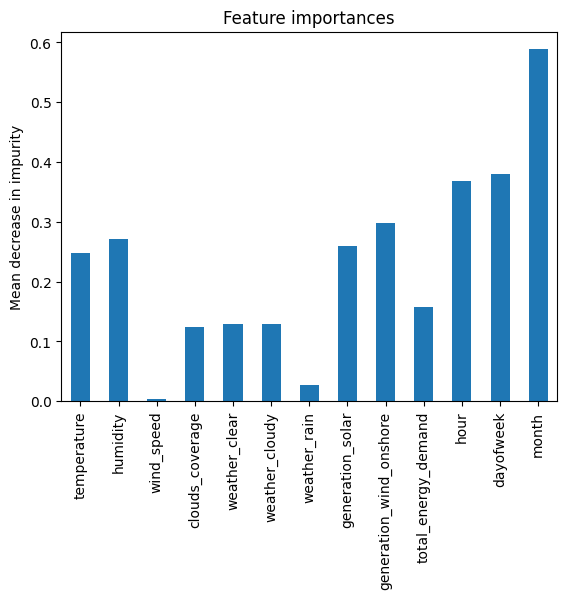

In [9]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=43, n_jobs=2
)
KNN_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
KNN_importances.plot.bar()
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity") # how much a feature reduces impurity on average,
#source: https://medium.com/@aneesha161994/gini-impurity-vs-gini-importance-vs-mean-decrease-impurity-51408bdd0cf1
#source 2: https://scikit-learn.org/stable/modules/permutation_importance.html

Auf den Diagramm sieht man die features aufgeteilt. Kurz gesagt, die Funktion hat bei jeden feature paar zufällige Werte gegeben und geschaut, wie sich das Resultat ändert. Nach diesen Verfahren sieht man klar, dass **der Monat die grösste Rolle bei der Preis spielt**.

# Messmetrik
Die Messmetrik gibt eine Bewertung einen Modell. Mit gleichen Messmetrik kann man unter verschiedenen Modellen vergleichen, wie gut sie sind. Für die Messmetrik wähle ich Mean Squard Error, da der Model auf Regression basiert.

In [10]:
from sklearn.metrics import mean_squared_error

y_true = y_test

y_pred = best_model.predict(X_test)

print(f"Mean Squared Error: {mean_squared_error(y_true,y_pred):.2f}")

Mean Squared Error: 63.65


# Sensivität und Spezifität
Das Modell basiert auf Regression, was am bisschen die nächsten Berechnungen schwieriger macht. Das Modell ist nicht perfekt und ich habe entschlossen, die Toleranz auf 10% zu setzen. Das Treff kann 10% von der richtige Preis abweichen. Das erlaubt die Frage zu stellen "Hat das Modell die richtige Preis für die Situation gefunden oder nicht?"

In [7]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

y_true = y_test.values.ravel()
y_pred = best_model.predict(X_test)
tolerance = 0.10

y_true_binary = np.ones_like(y_true)
y_pred_binary = np.abs(y_pred - y_true) <= (tolerance * y_true)
y_pred_binary = y_pred_binary.astype(int)

precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 1.00
Recall: 0.61


# Ist das Modell gut oder nicht? - die Hypothese
Anhand Daten über der Wetterlage und Stromproduktion in Valencia, Spanien, habe ich das Preis-Vorhersage Modell erstellt. Für mein erstes Mal habe ich am meisten interessante features gewählt wie die Solarstromerzeugung, die Temperatur und die Bewölkung beibehalten und die einfache Stromerzeugung aus Kohlekraftwerken weggelassen. Die Vorhersagen erreichen in Tests eine Genauigkeit von 45%, sind aber trotzdem glaubwürdig. Nach einer Analyse sieht man, dass es stark von Zeit abhängig wird.  
Meiner Meinung nach ist das Modell ausreichend trainiert und bereit. Ich vermute aber, da wichtigere features weggelassen sind, kann das Model zusammenhänge nicht gut verstehen. (94)